In [65]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, Dropout, Bidirectional, BatchNormalization, Conv2D, MaxPool2D, GRU, TimeDistributed
from matplotlib import pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [66]:
data_f = open("features.pickle","rb")
data = pickle.load(data_f)
data_f.close()

In [67]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)

(8732,) (8732,)


In [68]:
X = np.empty([8732, 128])
for i in range(8732):
    X[i] = (X_[i])

In [69]:
Y = to_categorical(Y)

In [70]:
print(X.shape, Y.shape)

(8732, 128) (8732, 10)


In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1, stratify=Y)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(6549, 128) (2183, 128) (6549, 10) (2183, 10)


In [72]:
X_train = X_train.reshape(6549, 16, 8)
X_test  = X_test.reshape(2183, 16, 8)

# X_train, X_test shape : (total # of training examples, sequence_length, input_dim)
# Y_train, Y_test shape : (total # of training examples, # output classes)

#X_train_cnn = X_train.reshape(6549, 16, 8, 1)
#X_test_cnn  = X_test.reshape(2183, 16, 8, 1)

In [73]:
def get_lstm_model():
    model = Sequential()
    model.add(LSTM(units=128, dropout=0.05, recurrent_dropout=0, return_sequences=True, input_shape=(16, 8)))
    model.add(LSTM(units=32,  dropout=0.05, recurrent_dropout=0, return_sequences=False))
    model.add(Dense(units=10, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy",
                                                                              keras.metrics.AUC(name='AUC'),
                                                                              keras.metrics.TruePositives(name='TruePositives'),
                                                                              keras.metrics.FalsePositives(name='FalsePositives'),
                                                                              keras.metrics.TrueNegatives(name='TrueNegatives'),
                                                                              keras.metrics.FalseNegatives(name='FalseNegatives')])
    return model

In [74]:
def get_bi_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, dropout=0.05, recurrent_dropout=0, return_sequences=True, input_shape=(16, 8))))
    model.add(Bidirectional(LSTM(units=32,  dropout=0.05, recurrent_dropout=0, return_sequences=False)))
    model.add((Dense(units=10, activation="softmax")))
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy",
                                                                              keras.metrics.AUC(name='AUC'),
                                                                              keras.metrics.TruePositives(name='TruePositives'),
                                                                              keras.metrics.FalsePositives(name='FalsePositives'),
                                                                              keras.metrics.TrueNegatives(name='TrueNegatives'),
                                                                              keras.metrics.FalseNegatives(name='FalseNegatives')])
    return model

In [76]:
def get_cnn_model():
  model = Sequential()
  model.add(Conv2D(64, (3, 3), padding = "same", activation = "tanh", input_shape = (16, 8, 1)))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, (3, 3), padding = "same", activation = "tanh"))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(1024, activation = "tanh"))
  model.add(Dense(10, activation = "softmax"))
  model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy",
                                                                              keras.metrics.AUC(name='AUC'),
                                                                              keras.metrics.TruePositives(name='TruePositives'),
                                                                              keras.metrics.FalsePositives(name='FalsePositives'),
                                                                              keras.metrics.TrueNegatives(name='TrueNegatives'),
                                                                              keras.metrics.FalseNegatives(name='FalseNegatives')])
  return model

In [77]:
def get_gru_model():
  model = Sequential()
  model.add(keras.layers.GRU(128, input_shape=(16, 8)))
  model.add(keras.layers.Dense(128, activation="relu"))
  model.add(keras.layers.Dense(10, activation = "softmax"))
  model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy",
                                                                              keras.metrics.AUC(name='AUC'),
                                                                              keras.metrics.TruePositives(name='TruePositives'),
                                                                              keras.metrics.FalsePositives(name='FalsePositives'),
                                                                              keras.metrics.TrueNegatives(name='TrueNegatives'),
                                                                              keras.metrics.FalseNegatives(name='FalseNegatives')])
  return model

In [78]:
def train_model(model, X_tr, Y_tr, X_te, Y_te):
    loss = list()
    accuracy = list()
    for _ in range(85):
        hist = model.fit(X_tr, Y_tr, epochs = 1, batch_size = 50, validation_data = (X_te, Y_te), verbose=1)
        loss.append(hist.history['loss'][0])
        accuracy.append(hist.history['accuracy'][0])
    return loss, accuracy

In [85]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

#  print('Legitimate Transactions Detected (True Negatives)              : ', cm[0][0])
#  print('Legitimate Transactions Incorrectly Detected (False Positives) : ', cm[0][1])
#  print('Fraudulent Transactions Missed (False Negatives)               : ', cm[1][0])
#  print('Fraudulent Transactions Detected (True Positives)              : ', cm[1][1])
#  print('Total Fraudulent Transactions                                  : ', np.sum(cm[1]))

In [91]:
def evaluate_maodel(model, Xt, Yt):
  baseline_results = model.evaluate(Xt, Yt, batch_size=50, verbose=0)
  for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value, '\n')
  train_predictions_baseline = np.argmax(model.predict(X_train, batch_size=50), axis=1)
  test_predictions_baseline = np.argmax(model.predict(X_test, batch_size=50), axis=1)
  plot_cm(np.argmax(Yt, axis=1), test_predictions_baseline)

In [81]:
loss_results = pd.DataFrame()
acc_results = pd.DataFrame()

In [ ]:
model1 = get_lstm_model()
loss_results['lstm'], acc_results['lstm'] = train_model(model1, X_train, Y_train, X_test, Y_test)

loss :  0.8482949733734131 

accuracy :  0.7695831656455994 

AUC :  0.9591568112373352 

TruePositives :  1611.0 

FalsePositives :  357.0 

TrueNegatives :  19290.0 

FalseNegatives :  572.0 



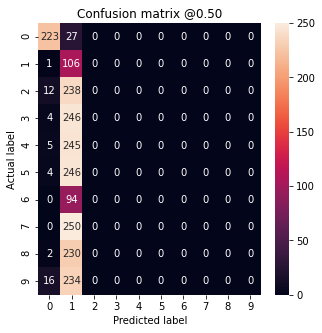

In [87]:
model1.save("model_lstm.h5")
#model1 = keras.models.load_model('/content/model_lstm.h5')
evaluate_maodel(model1, X_test, Y_test)

In [ ]:
model2 = get_bi_lstm_model()
loss_results['bi_lstm'], acc_results['bi_lstm'] = train_model(model2, X_train, Y_train, X_test, Y_test)

loss :  0.6887673139572144 

accuracy :  0.8373797535896301 

AUC :  0.968420147895813 

TruePositives :  1805.0 

FalsePositives :  307.0 

TrueNegatives :  19340.0 

FalseNegatives :  378.0 



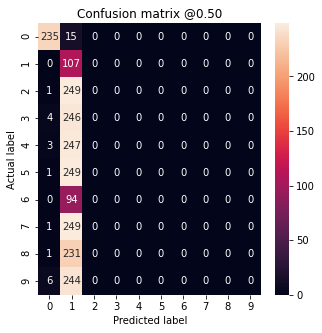

In [92]:
#model2.save("model_bi_lstm.h5")
model2 = keras.models.load_model('/content/model_bi_lstm.h5')
evaluate_maodel(model2, X_test, Y_test)

In [ ]:
model3 = get_cnn_model()
loss_results['cnn'], acc_results['cnn'] = train_model(model3, X_train_cnn, Y_train, X_test_cnn, Y_test)

In [ ]:
#model3.save("model_cnn.h5")
model3 = keras.models.load_model('/content/model_cnn.h5')
evaluate_maodel(model3, X_test_cnn, Y_test)

In [ ]:
model4 = get_gru_model()
loss_results['gru'], acc_results['gru'] = train_model(model4, X_train, Y_train, X_test, Y_test)

loss :  1.328805923461914 

accuracy :  0.7911131381988525 

AUC :  0.9389766454696655 

TruePositives :  1694.0 

FalsePositives :  404.0 

TrueNegatives :  19243.0 

FalseNegatives :  489.0 



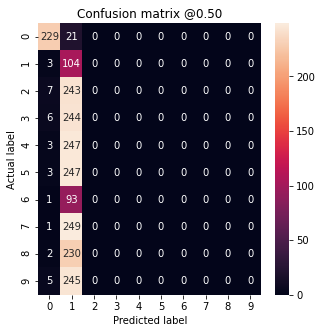

In [94]:
model4.save("model_gru.h5")
#model4 = keras.models.load_model('/content/model_gru.h5')
evaluate_maodel(model4, X_test, Y_test)

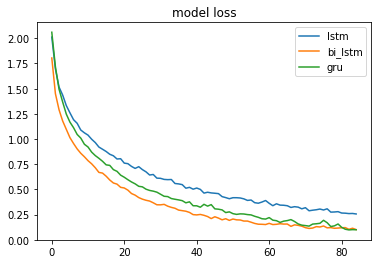

In [95]:
loss_results.plot()
plt.title('model loss')
plt.show()

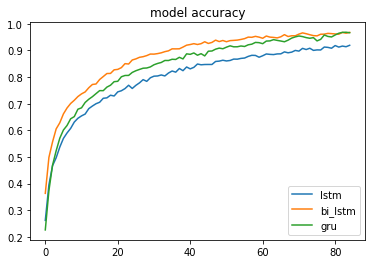

In [96]:
acc_results.plot()
plt.title('model accuracy')
plt.show()

In [ ]:
import librosa

class_labels = ['airconditioner', 'carhorn', 'childrenplaying', 'dogbark', 
                'drilling', 'engineidling', 'gunshot', 'jackhammer',
                'siren', 'street_music']

In [ ]:
def prediction(path):
  K, sample_rate = librosa.load(path, res_type='kaiser_fast')
  test = np.mean(librosa.feature.melspectrogram(y=K, sr=sample_rate).T,axis=0)
  test = np.array(test)
  test = test.transpose()
  test = test.reshape(16, 8)
  test_cnn = test.reshape(16, 8, 1)
  q1 = class_labels[np.argmax(model1.predict(np.array([test,]))[0])]
  q2 = class_labels[np.argmax(model2.predict(np.array([test,]))[0])]
  q3 = class_labels[np.argmax(model3.predict(np.array([test_cnn,]))[0])]
  print(f'LSTM-----prediction : {q1}\nBiLSTM---prediction : {q2}\nCNN------prediction : {q3}') 

In [ ]:
path = '/content/001ca53d.wav'
sound = prediction(path)

LSTM-----prediction : street_music
BiLSTM---prediction : street_music
CNN------prediction : street_music
